In [1]:
# Installing datasets for Hugging Face
!pip install --upgrade pip
!pip install datasets torch torchvision transformers
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
  Attempting uninstall: datasets
    Found existing installation: datasets 3.0.1
    Uninstalling datasets-3.0.1:
      Successfully uninstalled datasets-3.0.1


In [46]:
!pip install -U albumentations

In [47]:
# importing packages
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from datasets import load_dataset, load_from_disk
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# import tqdm
from torchvision import transforms
from torchvision.tv_tensors import BoundingBoxes, Image
from PIL import Image as PILImage

In [48]:
# Load the CelebA dataset from Hugging Face
# https://huggingface.co/datasets/hfaus/CelebA_bbox_and_facepoints
dataset = load_dataset("hfaus/CelebA_bbox_and_facepoints", trust_remote_code=True)

In [49]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 # Added import here
def get_train_transforms(): # v2
    return A.Compose([
        A.Resize(224, 224),  # Resize images to 224x224
        A.RandomBrightnessContrast(p=0.5),  # Randomly change brightness and contrast
        A.GaussianBlur(p=0.5),  # Apply Gaussian blur
        A.GaussNoise(p=0.5),  # Add Gaussian noise
        A.ImageCompression(compression_type='jpeg', quality_range=(70, 100), p=0.5),  # Simulate compression artifacts
        A.HueSaturationValue(p=0.5),  # Randomly change hue, saturation, and value
        A.MotionBlur(p=0.5),  # Apply motion blur
        A.ToGray(p=0.5),  # Convert image to grayscale
        A.HorizontalFlip(p=0.5),  # Horizontally flip the image
        A.RandomRotate90(p=0.5),  # Rotate the image by 90 degrees
        # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),  # Randomly shift, scale, and rotate (problem)
        A.Affine(scale=(0.9, 1.1), translate_percent=(0.1, 0.1), rotate=(-15, 15), p=0.5), # Try Uncommenting this and run and see it is working
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Normalize the image
        ToTensorV2(),  # Convert image to PyTorch tensor
    ], bbox_params=A.BboxParams(format='coco', label_fields=['labels'], clip=True, min_area=1, min_visibility=0.3, filter_invalid_bboxes=True)) # change to 0.02 if not working 

def get_minimal_transforms():
    return A.Compose([
        A.Resize(224, 224),  # Resize images to 224x224
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Normalize the image
        ToTensorV2(),  # Convert image to PyTorch tensor
    ], bbox_params=A.BboxParams(format='coco', label_fields=['labels'], clip=True, min_area=1, min_visibility=0.3, filter_invalid_bboxes=True))


class CelebADataset(Dataset):
    def __init__(self, dataset, transforms=None, minimal_transforms=None):
        self.dataset = dataset
        self.transforms = transforms
        self.minimal_transforms = minimal_transforms

    def __len__(self):
        return len(self.dataset)


    def clamp_bboxes(self, bboxes, hight, width, margin=1):
      """ 
      Clamps the bounding boxes to ensure they are within the image boundaries.
      Args:
        bboxes: A list of bounding boxes in the coco format [x_min, y_min, bbox_hight, bbox_width].
        hight: The height of the image.
        width: The width of the image.
      Returns:
        A list of clamped bounding boxes.
      """

      clamped_bboxes = []

      for bbox in bboxes:
          x_min, y_min, bbox_hight, bbox_width = bbox

          x_max = x_min + bbox_width
          y_max = y_min + bbox_hight

          x_min = max(margin, x_min)
          y_min = max(margin, y_min)
          x_max = min(width - margin, x_max)
          y_max = min(hight - margin, y_max)

          bbox_hight = y_max - y_min
          bbox_width = x_max - x_min

          clamped_bboxes.append([x_min, y_min, bbox_hight, bbox_width])

      return clamped_bboxes


    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = np.array(example['image'])
        bboxes = [example['bbox']]
        labels = [0]  # Dummy label; adjust as necessary for your use case

        if len(bboxes) == 0:
            bboxes = [[1, 1, 1, 1]]

        original_height, original_width = image.shape[:2]

        bboxes = self.clamp_bboxes(bboxes, original_height, original_width, margin=1)

        if self.transforms:
            augmented = self.transforms(image=image, bboxes=bboxes, labels=labels)
            image = augmented['image']
            bboxes = augmented['bboxes']

        bboxes = self.clamp_bboxes(bboxes, 224, 224, 1)

        if len(bboxes) == 0:
            bboxes = [[1, 1, 1, 1]]

        return image, torch.tensor(bboxes[0], dtype=torch.float32)

In [50]:
# Split the dataset into train, test, and validation
train_data = dataset['train']
# Turns out that test and validation data are corrupt :)               ...   <^_^>

# Create dataset instances for each split
# train_dataset = CelebADataset(train_data) # v1

train_transforms = get_train_transforms() # v2
minimal_transforms = get_minimal_transforms()
train_dataset = CelebADataset(train_data, transforms=get_minimal_transforms(), minimal_transforms=minimal_transforms)

# train_dataset = CelebADataset(train_data) # v3


# Define the desired sizes for each split
train_size = len(train_dataset) - 10000  # Original train size minus test and val sizes
test_size = 5000
val_size = 5000

# Split the original training dataset
train_dataset, test_dataset, val_dataset = random_split(
    train_dataset, [train_size, test_size, val_size],
    generator=torch.Generator().manual_seed(42)  # Set seed for reproducibility
)

# DataLoader for batch processing /// , num_workers=4, pin_memory=True is for gpu
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

------------------------------ training dataset samples ------------------------------


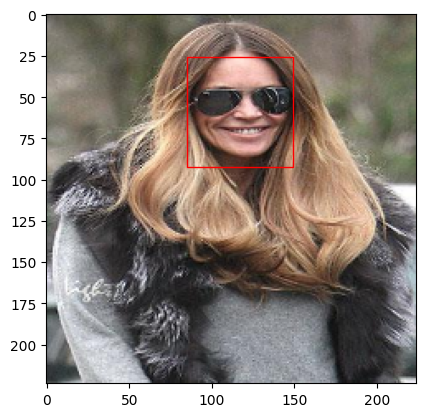

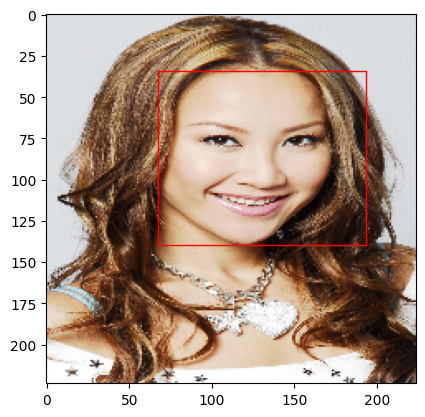

------------------------------ testing dataset samples ------------------------------


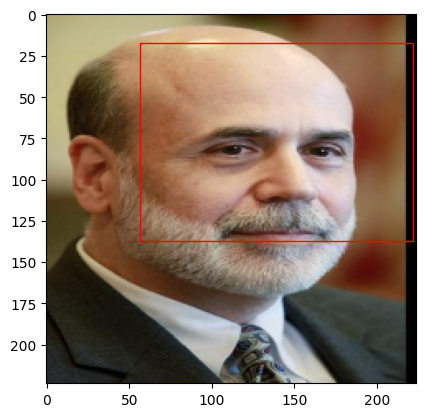

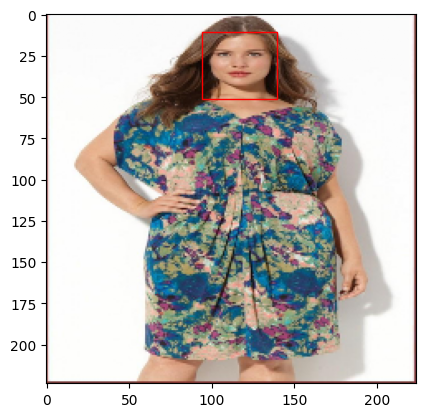

------------------------------ validation dataset samples ------------------------------


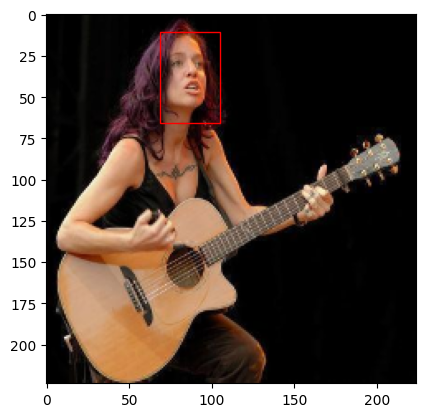

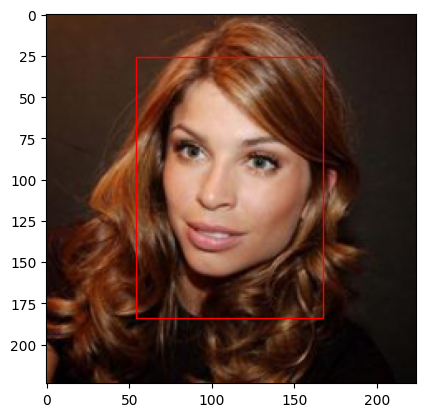

In [51]:
def show_image_with_bbox_and_landmarks_resized(dataset_instance, index):
  image, bbox = dataset_instance[index]
  image = image.permute(1, 2, 0).numpy()  # Convert to numpy and correct channel order
  # Undo the normalization
  image = (image * 0.5) + 0.5


  plt.imshow(image)
  ax = plt.gca()

  # Draw bounding box using x1, y1, width, height
  rect = patches.Rectangle(
      (bbox[0], bbox[1]),  # Using x1, y1 as starting point
      bbox[2],             # Using width
      bbox[3],             # Using height
      linewidth=1,
      edgecolor='r',
      facecolor='none'
  )
  ax.add_patch(rect)

  plt.show()

# Example usage with the celebA_dataset instance
size_dashes = 30
print(f"{'-' * size_dashes} training dataset samples {'-' * size_dashes}")
for i in range(2):
  r = np.random.randint(0, 162770 - 5000 * 2)
  show_image_with_bbox_and_landmarks_resized(train_dataset, r)
print(f"{'-' * size_dashes} testing dataset samples {'-' * size_dashes}")
for i in range(2):
  r = np.random.randint(0, 5000)
  show_image_with_bbox_and_landmarks_resized(test_dataset, r)
print(f"{'-' * size_dashes} validation dataset samples {'-' * size_dashes}")
for i in range(2):
  r = np.random.randint(0, 5000)
  show_image_with_bbox_and_landmarks_resized(val_dataset, r)

In [52]:
class FaceBBoxModel(nn.Module): # v5
    def __init__(self):
        super(FaceBBoxModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers for bounding box prediction
        self.fc_bbox = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),  # Input size matches the flattened conv layer output
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4)  # Output: [x1, y1, width, height]
        )

    def forward(self, x):
        # Convolutional layers with Batch Norm and Pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        # Flatten the output from the convolutional layers
        x = x.view(-1, 256 * 7 * 7)

        # Bounding box prediction
        bbox_output = self.fc_bbox(x)

        return bbox_output

In [53]:
def save_model(model, path):
  """Saves the model's state dictionary to the specified path.

  Args:
    model: The PyTorch model to save.
    path: The path where the model will be saved.
  """
  torch.save(model.state_dict(), path)
  print(f"Model saved to {path}")

def load_model(model, path, device):
    """Loads the model's state dictionary from the specified path.

    Args:
      model: The PyTorch model to load the state dictionary into.
      path: The path where the model is saved.
      device: The device to load the model onto (e.g., 'cuda' or 'cpu').
    """
    state_dict = torch.load(path, map_location=device, weights_only=True)  # Explicitly load the state_dict
    model.load_state_dict(state_dict)
    print(f"Model loaded from {path}")
    return model


In [54]:
# Using TPU
# !pip install cloud-tpu-client==0.10
# !pip install torch_xla

In [55]:
# # Using TPU
# import torch_xla
# import torch_xla.core.xla_model as xm
# from torch_xla.distributed.parallel_loader import ParallelLoader

In [56]:
# Instantiate the model, criterion, optimizer, scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = xm.xla_device()  # Use TPU device uncomment if using TPU
# train_loader = ParallelLoader(train_loader, [device]).per_device_loader(device)
# val_loader = ParallelLoader(val_loader, [device]).per_device_loader(device)
# test_loader = ParallelLoader(test_loader, [device]).per_device_loader(device)

model = FaceBBoxModel().to(device)
# bbox_criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define the criterion, optimizer, and scheduler
bbox_criterion = nn.SmoothL1Loss()      # lr=0.005
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=1)

In [57]:
# Load Already Trained Model
# model = load_model(model, '/kaggle/working/best_model.pth', device)
model = load_model(model, '/kaggle/input/bbox_model_v5_epoch_8/pytorch/default/1/bbox_v5.pth', device)

Model loaded from /kaggle/input/bbox_model_v5_epoch_8/pytorch/default/1/bbox_v5.pth


In [58]:
# Training
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop


bbox_losses = []

def train_model(model, train_loader, val_loader, optimizer, scheduler, device, bbox_criterion, num_epochs=10, patience=3):
    train_bbox_loss, val_bbox_loss = [], []
    early_stopping = EarlyStopping(patience=patience, min_delta=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss_bbox = 0.0

        for i, (images, bboxes) in enumerate(train_loader):
            images, bboxes = images.to(device), bboxes.to(device)  # comment this if you are using tpu
            optimizer.zero_grad()

            pred_bboxes = model(images)
            loss_bbox = bbox_criterion(pred_bboxes, bboxes)

            loss_bbox.backward()
            optimizer.step()

            running_loss_bbox += loss_bbox.item()

            if i % 200 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{i}/{len(train_loader)}], BBox Loss: {loss_bbox.item():.4f}")

            # TPU memory management
            # del images, bboxes, pred_bboxes, loss_bbox
            # xm.mark_step()

        
        avg_train_loss_bbox = running_loss_bbox / len(train_loader)
        train_bbox_loss.append(avg_train_loss_bbox)

        model.eval()
        val_running_loss_bbox = 0.0
        with torch.no_grad():
            for val_images, val_bboxes in val_loader:
                val_images, val_bboxes = val_images.to(device), val_bboxes.to(device) # comment this if you are using tpu
                val_pred_bboxes = model(val_images)
                val_loss_bbox = bbox_criterion(val_pred_bboxes, val_bboxes)
                val_running_loss_bbox += val_loss_bbox.item()

                # del val_images, val_bboxes, val_pred_bboxes, val_loss_bbox
                # xm.mark_step()
        
        avg_val_loss_bbox = val_running_loss_bbox / len(val_loader)
        val_bbox_loss.append(avg_val_loss_bbox)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train BBox Loss: {avg_train_loss_bbox:.4f}, Validation BBox Loss: {avg_val_loss_bbox:.4f}")

        scheduler.step(avg_val_loss_bbox)

        if early_stopping(avg_val_loss_bbox):
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

        if early_stopping.counter == 0:
            save_model(model, f"/kaggle/working/bbox_v5_augmented_epoch_{epoch + 1}.pth")
            print(f"Model saved at epoch {epoch + 1}.")


    print("Training completed.")
    return train_bbox_loss, val_bbox_loss

In [59]:
train_bbox_loss, val_bbox_loss = train_model(
    model, train_loader, val_loader, optimizer, scheduler, device, bbox_criterion, num_epochs=1, patience=1
)

Epoch [1/1], Batch [0/2388], BBox Loss: 4.4160
Epoch [1/1], Batch [200/2388], BBox Loss: 18.3692
Epoch [1/1], Batch [400/2388], BBox Loss: 11.9146
Epoch [1/1], Batch [600/2388], BBox Loss: 9.7081
Epoch [1/1], Batch [800/2388], BBox Loss: 9.8612
Epoch [1/1], Batch [1000/2388], BBox Loss: 8.7609
Epoch [1/1], Batch [1200/2388], BBox Loss: 11.9373
Epoch [1/1], Batch [1400/2388], BBox Loss: 7.6256
Epoch [1/1], Batch [1600/2388], BBox Loss: 6.5015
Epoch [1/1], Batch [1800/2388], BBox Loss: 6.5687
Epoch [1/1], Batch [2000/2388], BBox Loss: 5.7984
Epoch [1/1], Batch [2200/2388], BBox Loss: 6.9033
Epoch [1/1], Train BBox Loss: 10.6395, Validation BBox Loss: 5.8263
Model saved to /kaggle/working/bbox_v5_augmented_epoch_1.pth
Model saved at epoch 1.
Training completed.


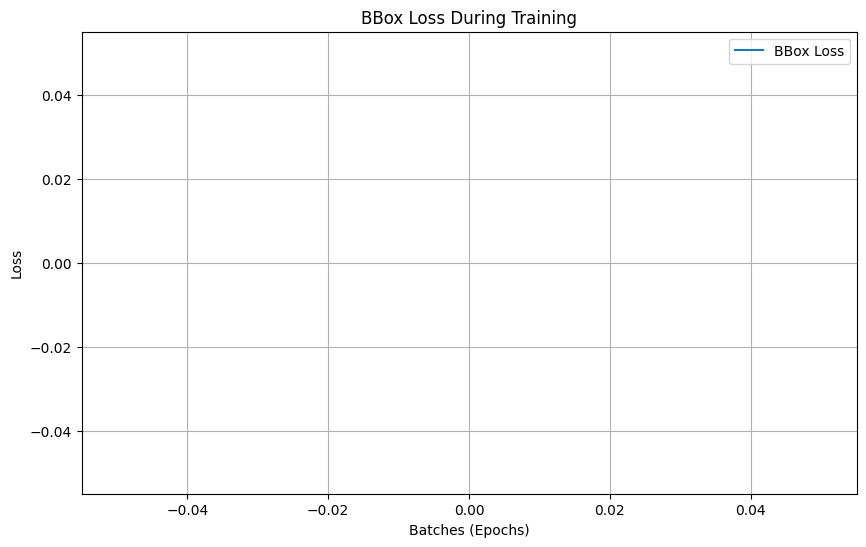

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, len(bbox_losses) + 1)), bbox_losses, label='BBox Loss')
plt.xlabel('Batches (Epochs)')
plt.ylabel('Loss')
plt.title('BBox Loss During Training')
plt.title('BBox Loss During Training')
plt.legend()
plt.grid(True)
plt.show()

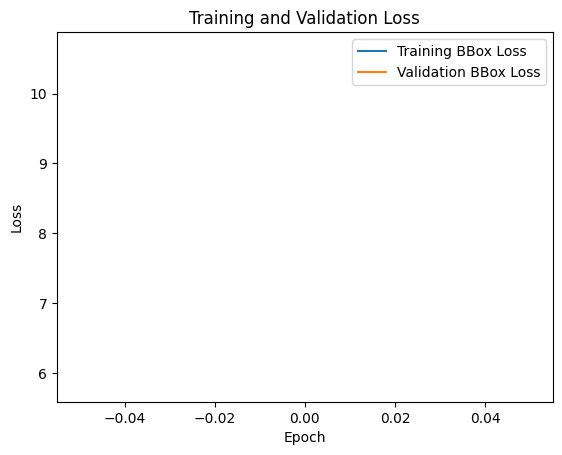

In [65]:
plt.plot(train_bbox_loss, label='Training BBox Loss')
plt.plot(val_bbox_loss, label='Validation BBox Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [70]:
def test_model():
    model.eval()
    test_loss_bbox = 0.0
    test_loss_landmarks = 0.0

    with torch.no_grad():
        for images, bboxes in test_loader:
            images, bboxes = images.to(device), bboxes.to(device) # comment this if you are using tpu

            # Forward pass
            pred_bboxes = model(images)

            # Calculate loss directly using tensors
            loss_bbox = bbox_criterion(pred_bboxes, bboxes)

            test_loss_bbox += loss_bbox.item()  # Get the scalar value of the loss

    print(f"Test BBox Loss: {test_loss_bbox / len(test_loader)}")

In [71]:
test_model()

Test BBox Loss: 5.745635950112645


In [75]:
def show_image_with_bboxes(image, gt_bbox, pred_bbox):
    """
    Displays an image with ground truth and predicted bounding boxes.

    Args:
        image: The image as a NumPy array.
        gt_bbox: The ground truth bounding box coordinates as [x1, y1, width, height].
        pred_bbox: The predicted bounding box coordinates as [x1, y1, width, height].
    """

    image = image.transpose(1, 2, 0)
    # Undo the normalization
    image = (image * 0.5) + 0.5
    if image.ndim == 2:
        image = np.stack((image,) * 3, axis=-1)

    plt.imshow(image)
    ax = plt.gca()

    # Draw ground truth bounding box in green
    rect_gt = patches.Rectangle(
        (gt_bbox[0], gt_bbox[1]),
        gt_bbox[2],
        gt_bbox[3],
        linewidth=1,
        edgecolor='g',
        facecolor='none',
        label='Ground Truth'
    )
    ax.add_patch(rect_gt)

    # Draw predicted bounding box in red
    rect_pred = patches.Rectangle(
        (pred_bbox[0], pred_bbox[1]),
        pred_bbox[2],
        pred_bbox[3],
        linewidth=1,
        edgecolor='r',
        facecolor='none',
        label='Predicted'
    )
    ax.add_patch(rect_pred)

    plt.legend()
    plt.show()

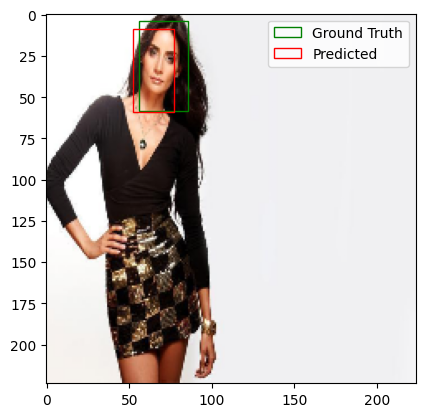

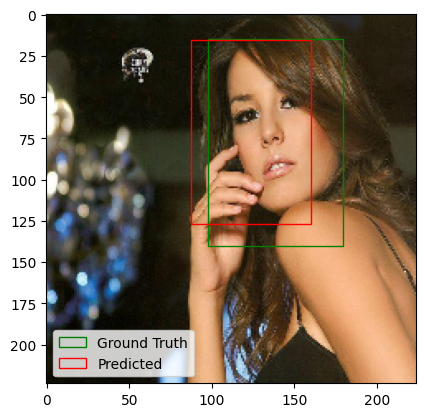

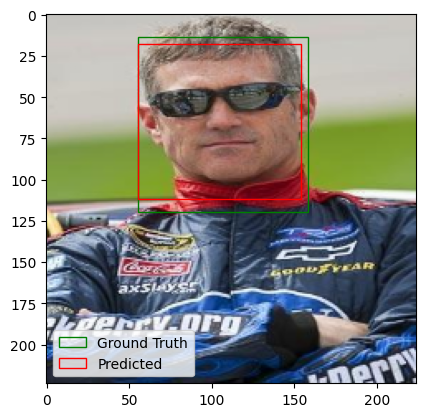

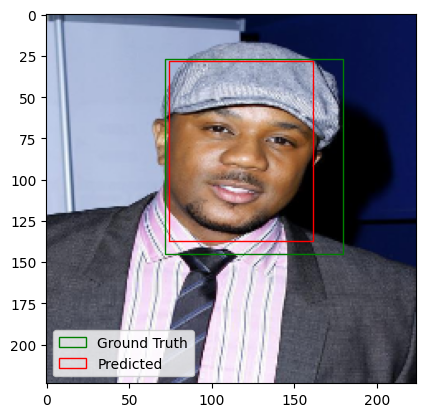

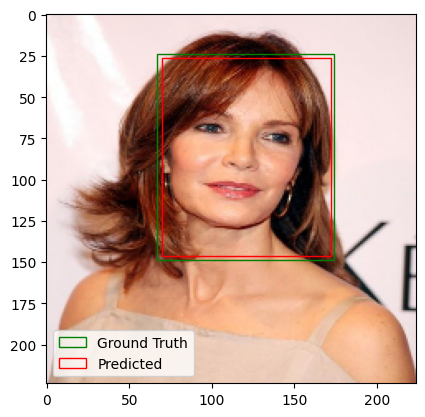

In [76]:
model.eval()
with torch.no_grad():
    for images, bboxes in test_loader:
        images, bboxes = images.to(device), bboxes.to(device) # comment this if you are using tpu
        pred_bboxes = model(images)
        images = images.cpu().numpy()
        bboxes = bboxes.cpu().numpy()
        pred_bboxes = pred_bboxes.cpu().numpy()
        for i in range(5):
            show_image_with_bboxes(images[i], bboxes[i], pred_bboxes[i])
        break